In [1]:
import os 
import numpy as np 
from PIL import Image 
import albumentations as A 
import torch

In [2]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

In [54]:
label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]
label_files[:4]

['Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'J2_jpg.rf.454825a65d0eafdc0586a7ff687848a4.txt',
 'M4_jpg.rf.2e4ce0d9adf16aa3d33a2ba77e567416.txt',
 'T23_jpg.rf.c8c9b394fc0b451c31f76bd56357a6d0.txt']

### In the original data.py file we have used the 'split' because we have only One dot but in my custom data I have multiple dots so to get the correct text file we have to split it from the back i.e. performe a right split 'rsplit' and taking the first part that's how we get our image base name

In [4]:
idx = 0 
label_file = label_files[idx]
image_file = label_file.rsplit('.',1)[0] + '.jpg'

label_path,image_path = os.path.join(labels_path,label_file),os.path.join(images_path,image_file)
label_path,image_path

('data/train/labels/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'data/train/images/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.jpg')

In [5]:
img = Image.open(image_path)
img_np = np.array(img)
print(img_np.shape)

(640, 480, 3)


In [6]:
annotations = open(label_path).read().strip().split(' ')
annotations

['25', '0.31875', '0.6703125', '0.3541666666666667', '0.25625']

In [7]:
annotations = open(label_path).read().strip().split('\n')
class_labels = []
bounding_boxes = []

for annotation in annotations:
    ann = annotation.split(" ")
    class_labels.append(int(ann[0]))
    bounding_boxes.append([float(x) for x in ann[1:]])

class_labels, bounding_boxes = np.array(class_labels,dtype=int), np.array(bounding_boxes,dtype=float)
class_labels, bounding_boxes

(array([25]), array([[0.31875   , 0.6703125 , 0.35416667, 0.25625   ]]))

In [8]:
transfrom = A.Compose(
    [
        A.Resize(500,500),
        A.RandomCrop(224,224,p=0.33),
        A.Resize(224,224),
        A.HorizontalFlip(p=0.6),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.pytorch.transforms.ToTensorV2()   
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

aug = transfrom(image= img_np,bboxes = bounding_boxes,class_labels = class_labels)
aug.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [9]:
aug_img = aug['image']
aug_boxes = aug['bboxes']
aug_labels = aug['class_labels']
print(aug_img.shape)
print(aug_boxes)
print(aug_labels)


torch.Size([3, 224, 224])
[[0.31875    0.67031252 0.35416667 0.25625002]]
[25]


In [10]:
aug_tensor = aug_img 
labels_tensor = torch.tensor(aug_labels,dtype=torch.long)
boxes_tensor = torch.tensor(aug_boxes,dtype=torch.float32)
# aug_tensor,labels_tensor,boxes_tensor
labels_tensor,boxes_tensor

(tensor([25]), tensor([[0.3187, 0.6703, 0.3542, 0.2563]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].


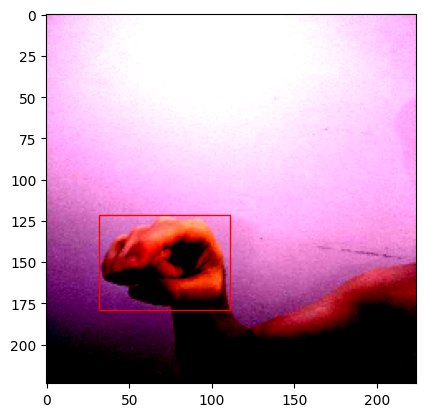

In [11]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 

plt.imshow(aug_tensor.permute(1,2,0))
abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for box in abs_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(
        plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin,fill = False, color ='red',linewidth = 1)
    )

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].


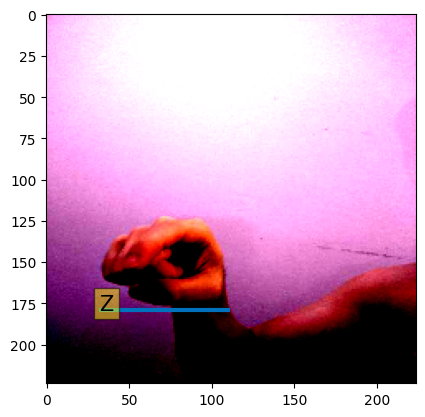

In [15]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 
from src.utils.setup import get_classes

plt.imshow(aug_tensor.permute(1,2,0))
ax = plt.gca()
CLASSES = get_classes()

abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for label,box in zip(labels_tensor,abs_boxes):
    xmin, ymin, xmax, ymin = box 
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,fill= False,color=(0.000, 0.447, 0.741),linewidth = 3))
    ax.text(xmin, ymin, f'{CLASSES[label]}', fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

plt.show()

In [50]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from colorama import Fore

from src.utils.boxes import rescale_bboxes, stacker
from src.utils.setup import get_classes
from src.utils.logger import get_logger
from src.utils.rich_handlers import DataLoaderHandler


class DETRData(Dataset):
    def __init__(self, path, train=True):
        super().__init__()
        self.path = path
        self.labels_path = os.path.join(self.path, 'labels')
        self.images_path = os.path.join(self.path, 'images')
        self.label_files = os.listdir(self.labels_path)
        self.labels = [f for f in self.label_files if f.endswith('.txt')]
        self.train = train

        # Initialize logger
        self.logger = get_logger("data_loader")
        self.data_handler = DataLoaderHandler()

        dataset_info = {
            "Dataset Path": self.path,
            "Mode": "Training" if train else "Testing",
            "Total Samples": len(self.labels),
            "Images Path": self.images_path,
            "Labels Path": self.labels_path
        }
        self.data_handler.log_dataset_stats(dataset_info)

        transform_list = [
            "Resize to 500x500",
            "Random Crop 224x224 (training only)",
            "Final Resize to 224x224",
            "Horizontal Flip p=0.5 (training only)",
            "Color Jitter (training only)",
            "Normalize (ImageNet stats)",
            "Convert to Tensor"
        ]
        self.data_handler.log_transform_info(transform_list)

    def safe_transform(self, image, bboxes, labels, max_attempts=50):
        self.transform = A.Compose(
            [
                A.Resize(500, 500),
                *([A.RandomCrop(width=224, height=224, p=0.33)] if self.train else []),
                A.Resize(224, 224),
                *([A.HorizontalFlip(p=0.5)] if self.train else []),
                *([A.ColorJitter(brightness=0.3, contrast=0.3,
                                 saturation=0.3, hue=0.3, p=0.5)] if self.train else []),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ],
            bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
        )

        for attempt in range(max_attempts):
            try:
                transformed = self.transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=labels
                )
                if len(transformed['bboxes']) > 0:
                    return transformed
            except:
                continue

        return {
            'image': image,
            'bboxes': bboxes,
            'class_labels': labels
        }

    def __len__(self):
        return len(self.labels)

# idx = 0 
# label_file = label_files[idx]
# image_file = label_file.rsplit('.',1)[0] + '.jpg'

# label_path,image_path = os.path.join(labels_path,label_file),os.path.join(images_path,image_file)
# label_path,image_path

    def __getitem__(self, idx):
        label_path = os.path.join(self.labels_path, self.labels[idx])
        image_name = self.labels[idx].rsplit('.',1)[0]
        image_path = os.path.join(self.images_path, f'{image_name}.jpg')

        img = Image.open(image_path)
        with open(label_path, 'r') as f:
            annotations = f.readlines()

        class_labels = []
        bounding_boxes = []
        for annotation in annotations:
            ann = annotation.strip().split(' ')
            class_labels.append(int(ann[0]))
            bounding_boxes.append([float(x) for x in ann[1:]])

        bounding_boxes = np.array(bounding_boxes)
        class_labels = np.array(class_labels)

        augmented = self.safe_transform(
            image=np.array(img),
            bboxes=bounding_boxes,
            labels=class_labels
        )

        aug_img_tensor = augmented['image']
        aug_boxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
        aug_labels = torch.tensor(augmented['class_labels'], dtype=torch.long)

        return aug_img_tensor, {"labels": aug_labels, "boxes": aug_boxes}

In [51]:
dataset = DETRData("data/train", train=True)
dataloader = DataLoader(dataset, collate_fn=stacker, batch_size=4, drop_last=True)

X, y = next(iter(dataloader))
print(Fore.LIGHTCYAN_EX + str(y) + Fore.RESET)

CLASSES = get_classes()


        📊 Dataset Statistics        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value             ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/train        │
│ Mode          │ Training          │
│ Total Samples │ 996               │
│ Images Path   │ data/train/images │
│ Labels Path   │ data/train/labels │
└───────────────┴───────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[{'labels': tensor([25]), 'boxes': tensor([[0.6812, 0.6703, 0.3542, 0.2563]])}, {'labels': tensor([9]), 'boxes': tensor([[0.4625, 0.5009, 0.9250, 0.9982]])}, {'labels': tensor([12]), 'boxes': tensor([[0.4115, 0.4633, 0.4042, 0.3453]])}, {'labels': tensor([19]), 'boxes': tensor([[0.5167, 0.7312, 0.5896, 0.5375]])}]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..2.1694117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466563..2.2489083].


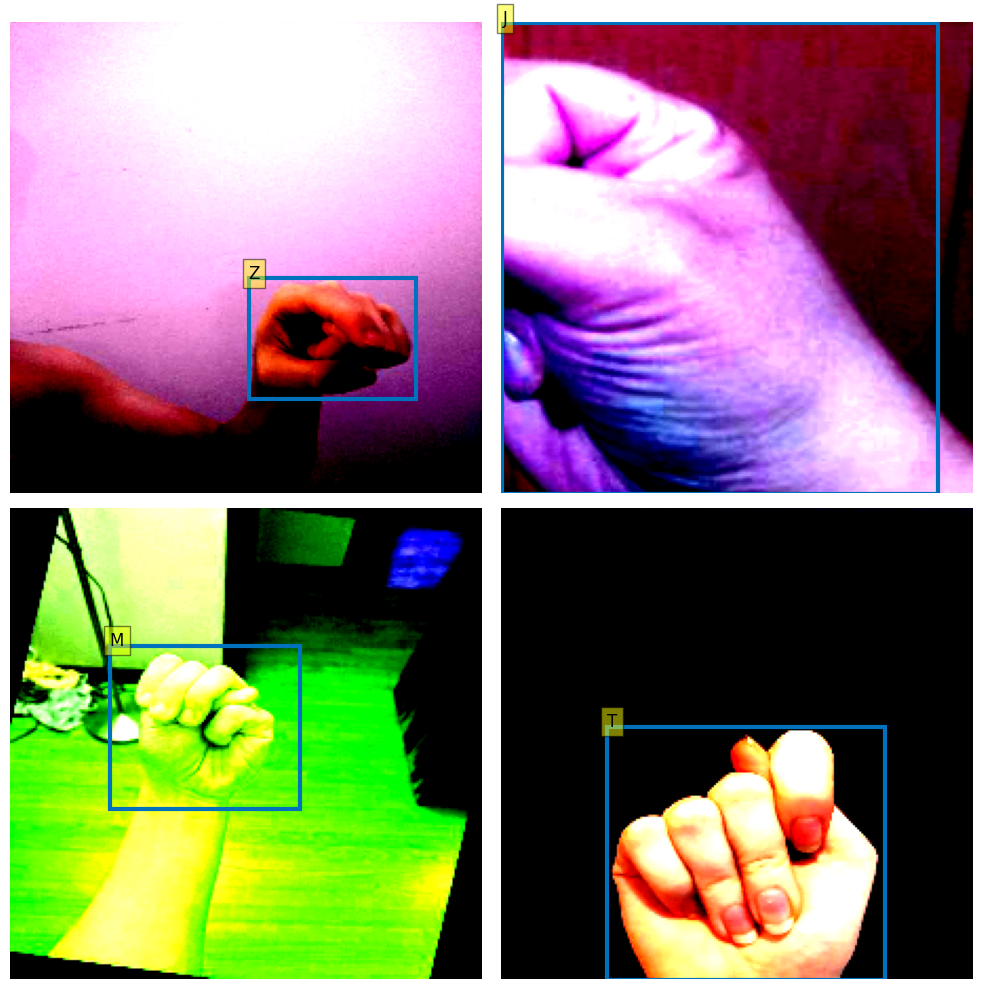

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.flatten()

for idx, (img, annotations, ax) in enumerate(zip(X, y, axs)):
    ax.imshow(img.permute(1, 2, 0))

    boxes = rescale_bboxes(annotations['boxes'], (224, 224))
    box_classes = annotations['labels']

    for cls, box in zip(box_classes, boxes):
        xmin, ymin, xmax, ymax = box.numpy()
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=(0, 0.447, 0.741), linewidth=3
        ))

        ax.text(xmin, ymin, CLASSES[cls], fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))

    ax.axis("off")

plt.tight_layout()
plt.show()


In [61]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]
label_file = label_files[4]
print(label_file)
image_file = label_file.rsplit('.',1)[0] + '.jpg' 
image_file

L23_jpg.rf.9871c514a88ee4257f04476802731971.txt


'L23_jpg.rf.9871c514a88ee4257f04476802731971.jpg'

In [76]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]

idx = 4
label_file = label_files[idx]
image_file = label_file.rsplit('.',1)[0] + '.jpg' 

label_path, image_path = os.path.join(labels_path, label_file), os.path.join(images_path,image_file)
label_path,image_path

transform = A.Compose([
    A.Resize(500, 500),
    A.RandomCrop(224, 224, p=0.33),
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    A.ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

img = Image.open(image_path)

annotations = open(label_path).read().strip().split('\n')
class_label = []
bounding_boxes = []

for ann in annotations:
    ann = ann.split(' ')
    class_label.append(int(ann[0]))
    bounding_boxes.append([float(x) for x in ann[1:]])

class_label, bounding_boxes = np.array(class_label,dtype=int), np.array(bounding_boxes,dtype=float)

def safe_transform(transform,image,bboxes,labels,max_attempts=10):
    for i in range(max_attempts):
        try:
            out = transform(image=image,bboxes=bboxes,class_labels=labels)
            fig,ax = plt.subplots(figsize=(4,4))
            ax.imshow(out['image'].permute(1,2,0))
            abs_boxes = rescale_bboxes(torch.tensor(out['bboxes']),(224,224))

            for box in abs_boxes:
                xmin, ymin, xmax, ymax = box
                ax.add_patch(
                    plt.Rectangle(
                        (xmin,ymin),
                        xmax-xmin,
                        ymax-ymin,
                        fill= False,
                        color = 'red',
                        linewidth = 2                   
                    )
                )
            
            ax.set_title(f"attempts {i+1} - Boxes: {len(out['bboxes'])}")
            ax.axis('off')
            plt.show()

            if len(out['bboxes'])>0:
                print(f"Accepted on attempt {i+1}")
                return out 
            
        except Exception as e:
            print(f'error at attempt {i+1}: {e}')
    
    print("All attempts failed — returning original image.")
    return {"image": image, "bboxes": bboxes, "class_labels": labels}



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].


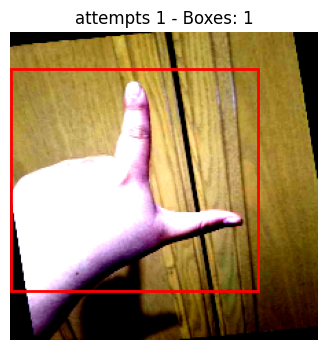

Accepted on attempt 1


In [77]:
out = safe_transform(
    transform=transform,
    image=np.array(img),
    bboxes=bounding_boxes,
    labels=class_label
)
